In [ ]:
#| hide
!pip install -Uqq nixtla

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

In [ ]:
#| hide
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#| hide
pd.set_option('future.no_silent_downcasting', True)

In [ ]:
#| hide
def plot_anomaly(df, anomaly_df, time_col = 'ts', target_col = 'y'):
    merged_df = pd.merge(df.tail(300), anomaly_df[[time_col, 'anomaly', 'TimeGPT']], on=time_col, how='left').fillna({'anomaly': False}).ffill()
    plt.figure(figsize=(12, 2))
    plt.plot(merged_df[time_col], merged_df[target_col], label='y', color='navy', alpha=0.8)
    plt.plot(merged_df[time_col], merged_df['TimeGPT'], label='TimeGPT', color='orchid', alpha=0.7)
    plt.scatter(merged_df.loc[merged_df['anomaly'], time_col], merged_df.loc[merged_df['anomaly'], target_col], color='orchid', label='Anomalies Detected')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Improve Detection Accuracy

This notebook shows how to enhance anomaly detection accuracy by controlling the detection process. TimeGPT uses its forecasting power to detect anomalies based on forecast errors. By optimizing forecast parameters and accuracy, you can significantly improve anomaly detection performance.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/capabilities/realtime-anomaly-detection/02_improve_detection_accuracy')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/capabilities/anomaly-detection/06_improve_detection_accuracy.ipynb)

In [ ]:
import pandas as pd
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

## 1 Conduct anomaly detection
After initializing an instance of `NixtlaClient`, let’s explore an example using the Peyton Manning dataset.

In [ ]:
df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/peyton-manning.csv',parse_dates = ['ds']).tail(200)

,unique_id,ds,y
2764,0,2015-07-05,6.499787
2765,0,2015-07-06,6.859615
2766,0,2015-07-07,6.881411
2767,0,2015-07-08,6.997596
2768,0,2015-07-09,7.152269


In [ ]:
# Base case for anomaly detection using detect_anomaly_realtime
anomaly_df = nixtla_client.detect_anomalies_realtime(df,
                                                    freq='D',
                                                    h=14,
                                                    level=90,
                                                    detection_size=100
                                                    )

INFO:nixtla.nixtla_client:Validating inputs...


INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Detection size is large. Using the entire series to compute the anomaly threshold...
INFO:nixtla.nixtla_client:Calling Online Anomaly Detector Endpoint...


/var/folders/mt/bm2h50kj2872xhymzl24djch0000gn/T/ipykernel_21069/2618285972.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df = pd.merge(df.tail(300), anomaly_df[[time_col, 'anomaly', 'TimeGPT']], on=time_col, how='left').fillna({'anomaly': False}).ffill()


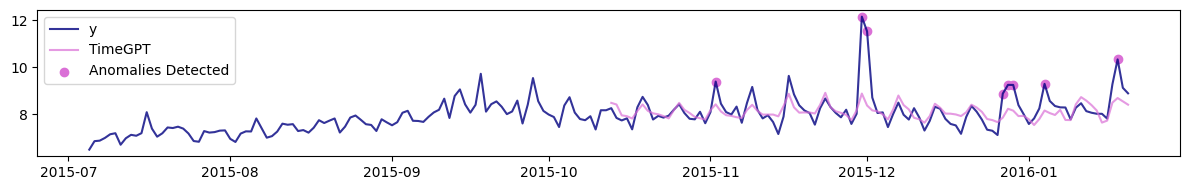

In [ ]:
plot_anomaly(df, anomaly_df, time_col = 'ds', target_col = 'y')

## 2. Improving the Anomaly Detection Process
To enhance anomaly detection, we will explore two approaches: finetuning the model to improve forecast accuracy and adjusting forecast horizons and step sizes to optimize how the time series is segmented and analyzed. These methods help tailor the process to your data for better results.

### 2.1 Finetune TimeGPT
TimeGPT uses forecast errors for anomaly detection, so improving forecast accuracy reduces noise in the errors, leading to better anomaly detection. You can fine-tune the model using the following parameters:
* `finetune_steps`: Number of steps for finetuning TimeGPT on new data.
* `finetune_depth`:  Intensity of fine-tuning, with options ranging from 1 to 5.
* `finetune_loss`: Loss function to be used during the fine-tuning process.

In [ ]:
anomaly_online_ft = nixtla_client.detect_anomalies_realtime(df,
                                                        freq='D',
                                                        h=14,
                                                        level=90,
                                                        detection_size=100,
                                                        finetune_steps = 10,    # Number of steps for fine-tuning TimeGPT on new data
                                                        finetune_depth = 2,     # Intensity of finetuning
                                                        finetune_loss = 'mae'   # Loss function used during the finetuning process
                                                        )

INFO:nixtla.nixtla_client:Validating inputs...


INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Detection size is large. Using the entire series to compute the anomaly threshold...
INFO:nixtla.nixtla_client:Calling Online Anomaly Detector Endpoint...


/var/folders/mt/bm2h50kj2872xhymzl24djch0000gn/T/ipykernel_21069/2618285972.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df = pd.merge(df.tail(300), anomaly_df[[time_col, 'anomaly', 'TimeGPT']], on=time_col, how='left').fillna({'anomaly': False}).ffill()


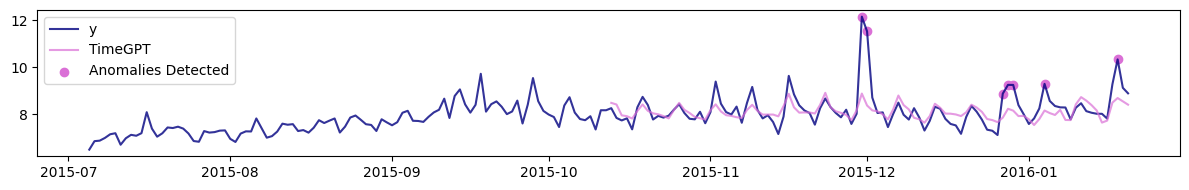

In [ ]:
plot_anomaly(df, anomaly_online_ft, time_col = 'ds', target_col = 'y')

### 2.2 Change forecast horizon and step
Similar to cross-validation, the anomaly detection method generates forecasts for historical data by splitting the time series into overlapping windows. The way these windows are defined can impact the anomaly detection results. Two key parameters control this process:
* `h`: Specifies how many steps into the future the forecast is made for each window.
* `step_size`: Determines the interval between the starting points of consecutive windows.

In [ ]:
anomaly_df_horizon = nixtla_client.detect_anomalies_realtime(df,
                                                            time_col='ds',
                                                            target_col='y',
                                                            freq='D',
                                                            h=2,                 # Forecast horizon
                                                            step_size = 1,       # Step size for moving through the time series data
                                                            level=90,            
                                                            detection_size=100
                                                            )

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Detection size is large. Using the entire series to compute the anomaly threshold...
INFO:nixtla.nixtla_client:Calling Online Anomaly Detector Endpoint...


/var/folders/mt/bm2h50kj2872xhymzl24djch0000gn/T/ipykernel_21069/2618285972.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df = pd.merge(df.tail(300), anomaly_df[[time_col, 'anomaly', 'TimeGPT']], on=time_col, how='left').fillna({'anomaly': False}).ffill()


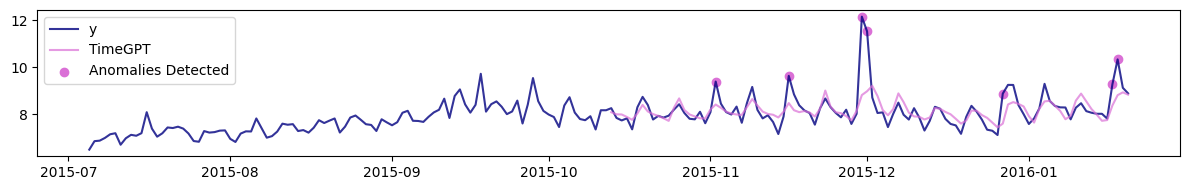

In [ ]:
plot_anomaly(df, anomaly_df_horizon, time_col = 'ds', target_col = 'y')

> 📘 **Balancing h and step_size depends on your data:** For frequent, short-lived anomalies, use a smaller `h` to focus on short-term predictions and a smaller `step_size` to increase overlap and sensitivity. For smooth trends or long-term patterns, use a larger `h` to capture broader anomalies and a larger `step_size` to reduce noise and computational cost.